In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tkinter import Image
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler

In [2]:
dataset_dir = 'Dataset'
train_dir = os.path.join(dataset_dir, 'Train')
validation_dir = os.path.join(dataset_dir, 'Validation')
test_dir = os.path.join(dataset_dir, 'Test')

In [3]:
base_path = "Dataset"

In [4]:
# Setting the path to our project folder
project_folder = "Dataset"

In [5]:
# Setting the image size and batch size
img_size = (224, 224)
batch_size = 64

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    project_folder + '/Train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    project_folder + '/Validation',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    project_folder + '/Test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
)

Found 4150 images belonging to 3 classes.
Found 1036 images belonging to 3 classes.
Found 659 images belonging to 3 classes.


In [18]:
# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [87]:
# Freeze the layers of VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Add custom layers on top of the base model
x = base_model.output
# Adding custom convolutional layers
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
# Flatten and add dense layers
x = Flatten()(x)
#x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
#x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

In [89]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

In [20]:
# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# Compile the model
vgg_model.compile(optimizer = Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [92]:
#Training the model
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    callbacks=[learning_rate_reduction],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1,
)

Epoch 1/15
64/64 [==============================] - 651s 10s/step - loss: 1.0293 - accuracy: 0.5702 - val_loss: 0.9590 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 2/15
64/64 [==============================] - 706s 11s/step - loss: 0.7716 - accuracy: 0.6904 - val_loss: 0.7054 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 3/15
64/64 [==============================] - 607s 9s/step - loss: 0.6798 - accuracy: 0.7406 - val_loss: 0.7114 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 4/15
64/64 [==============================] - 611s 10s/step - loss: 0.6087 - accuracy: 0.7627 - val_loss: 0.6895 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 5/15
64/64 [==============================] - 611s 10s/step - loss: 0.5756 - accuracy: 0.7792 - val_loss: 0.7347 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/15
64/64 [==============================] - 609s 10s/step - loss: 0.5409 - accuracy: 0.7944 - val_loss: 0.9050 - val_accuracy: 0.6895 - lr: 0.0010
Epoch 7/15
64/64 [==============================] - 610s 10s/step - los

In [93]:
scores1 = vgg_model.evaluate(validation_generator)
scores1

17/17 [==============================] - 120s 7s/step - loss: 0.6214 - accuracy: 0.7819


[0.6213631629943848, 0.7818532586097717]

In [94]:
scores2 = vgg_model.evaluate(test_generator)
scores2

11/11 [==============================] - 86s 8s/step - loss: 0.4887 - accuracy: 0.8313


[0.4887198805809021, 0.8313252925872803]

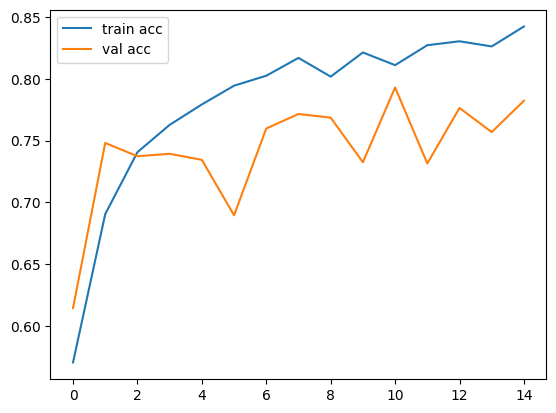

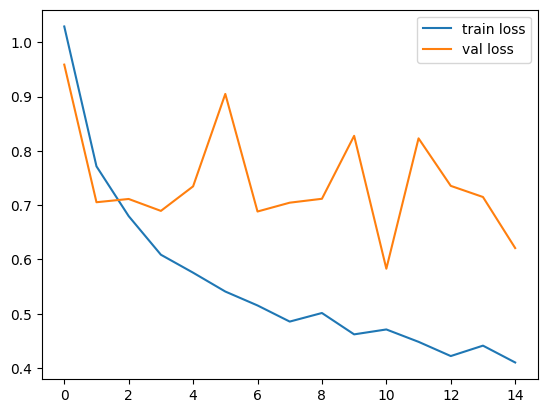

In [95]:
# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [7]:
valid_set1 = validation_datagen.flow_from_directory(project_folder + '/Validation',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                             shuffle=False)

Found 1036 images belonging to 3 classes.


17/17 [==============================] - 128s 7s/step


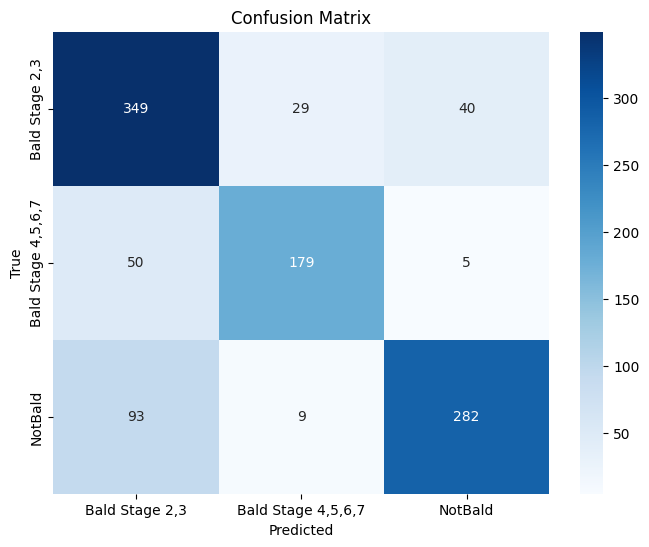

                    precision    recall  f1-score   support

    Bald Stage 2,3       0.71      0.83      0.77       418
Bald Stage 4,5,6,7       0.82      0.76      0.79       234
           NotBald       0.86      0.73      0.79       384

          accuracy                           0.78      1036
         macro avg       0.80      0.78      0.78      1036
      weighted avg       0.79      0.78      0.78      1036



In [97]:
Y_pred = vgg_model.predict(valid_set1, steps=len(valid_set1))
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_set1.classes
class_names = list(valid_set1.class_indices.keys())

# Menampilkan Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Menampilkan Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

In [98]:
# Saving the model
vgg_model.save("detection_model.keras")

In [99]:
# Simpan label
class_names = ['Bald Stage 2,3', 'Bald Stage 4,5,6,7', 'NotBald']
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [11]:
class_names = list(train_generator.class_indices.keys())
class_names

['Bald Stage 2,3', 'Bald Stage 4,5,6,7', 'NotBald']

In [10]:
# Function to detect baldness

def predict(model, img):
    # Mengonversi gambar ke array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Menambahkan dimensi batch

    # Melakukan prediksi
    predictions = model.predict(img_array)

    # Daftar nama kelas sesuai dengan urutan pelatihan model
    class_names = ['Bald Stage 2,3', 'Bald Stage 4,5,6,7', 'NotBald']

    # Mengambil kelas yang diprediksi dan tingkat kepercayaan
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

In [14]:
test_set = test_datagen.flow_from_directory(project_folder + '/Test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 664 images belonging to 3 classes.


1/1 [==============================] - 0s 402ms/step


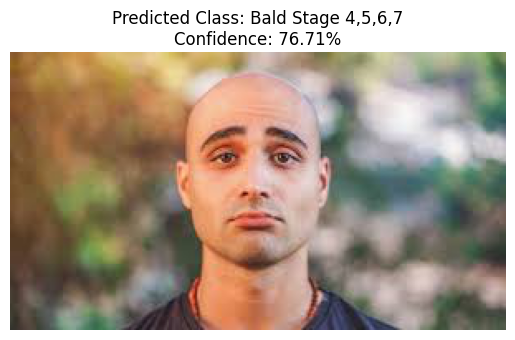

In [102]:
# Path to the image file
image_path = 'Dataset/images.jpg'

# Load the image and resize it to the input shape of your model
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (normalize pixel values)
img_array = img_array / 255.0

# Load the model
model_path = 'detection_model.keras'
model = tf.keras.models.load_model(model_path)

# Make predictions
predictions = vgg_model.predict(img_array)

# Mengambil kelas yang diprediksi dan tingkat kepercayaan
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the image
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 251ms/step


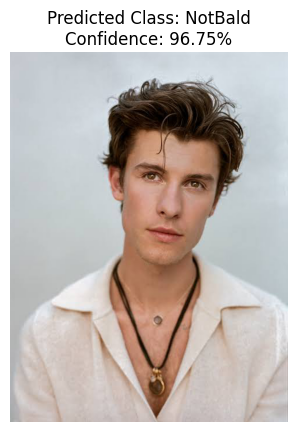

In [103]:
# Path ke file gambar
image_path = 'Dataset/images.jpeg'

# Memuat gambar dan mengubah ukurannya sesuai input model Anda
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess gambar (normalisasi nilai piksel)
img_array = img_array / 255.0

# Memuat model
model_path = 'detection_model.keras'
model = tf.keras.models.load_model(model_path)

# Make predictions
predictions = vgg_model.predict(img_array)

# Mengambil kelas yang diprediksi dan tingkat kepercayaan
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the image
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 225ms/step


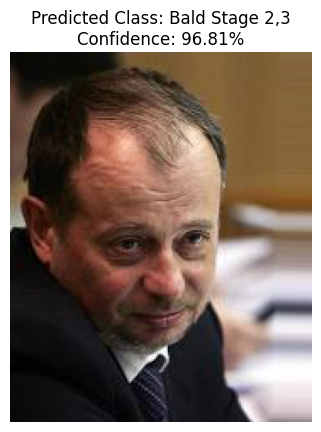

In [104]:
# Path ke file gambar
image_path = 'Dataset/gambar.jpg'

# Memuat gambar dan mengubah ukurannya sesuai input model Anda
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess gambar (normalisasi nilai piksel)
img_array = img_array / 255.0

# Memuat model
model_path = 'detection_model.keras'
model = tf.keras.models.load_model(model_path)

# Make predictions
predictions = vgg_model.predict(img_array)

# Mengambil kelas yang diprediksi dan tingkat kepercayaan
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * np.max(predictions[0]), 2)

# Display the image
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
plt.axis('off')
plt.show()

In [105]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(vgg_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_path = "assets/detection.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmplnh4hgn6\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmplnh4hgn6\assets
